# Algorithm implemented

- [Define and select data to achieve our goal](#select)
- [Adjust class distribution](#adjust)
- [Undersampling](#undersampling)
- [Split data](split)
- [Oversampling](#smote)
- [Select models](#models)
- Hyperparameter tuning 
- Train data
- Perform prediction

## Goal: To predict if a patient will be intubated if he/she has COVID and any of the conditions prevously explained

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read data
df = pd.read_csv('data1/positive.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,fecha_actualizacion,id_registro,origen,sector,entidad_um,sexo,entidad_nac,entidad_res,municipio_res,tipo_paciente,...,obesidad,renal_cronica,tabaquismo,otro_caso,resultado,migrante,pais_nacionalidad,pais_origen,uci,entidad_federativa
0,2020-07-16,149341,2,4.0,15,women,15.0,15,106.0,1,...,2.0,2.0,2.0,NaN,Positivo,NaN,Mexico,NaN,NaN,México
1,2020-07-16,14544b,2,4.0,9,women,9.0,15,104.0,1,...,2.0,2.0,2.0,NaN,Positivo,NaN,Mexico,NaN,NaN,México
2,2020-07-16,12a72b,2,4.0,9,women,9.0,15,121.0,1,...,2.0,2.0,2.0,NaN,Positivo,NaN,Mexico,NaN,NaN,México
3,2020-07-16,0b1fd9,2,4.0,9,men,15.0,15,81.0,1,...,2.0,2.0,1.0,NaN,Positivo,NaN,Mexico,NaN,NaN,México
4,2020-07-19,147f1f,2,4.0,15,men,9.0,15,33.0,2,...,2.0,2.0,2.0,NaN,Positivo,NaN,Mexico,NaN,2.0,México


In [3]:
df.shape

(356609, 36)

## Select data  <a name="select"></a>

In [4]:
# select cols
data = df[['sexo','edad', 'embarazo', 'diabetes', 'epoc', 'neumonia', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
           'obesidad', 'renal_cronica', 'tabaquismo', 'otra_com', 'intubado']]

In [5]:
# from float to int
selected_cols = ['sexo', 'entidad_res', 'edad']
columns = data.columns.tolist()

for i in columns:
    if i in selected_cols:
        pass
    
    else:
        data[i] = data[i].round().astype('Int64')

In [6]:
data.head()

,sexo,edad,embarazo,diabetes,epoc,neumonia,asma,inmusupr,hipertension,cardiovascular,obesidad,renal_cronica,tabaquismo,otra_com,intubado
0,women,30,2,2,2,2,2,2,2,2,2,2,2,2,NaN
1,women,29,2,2,2,2,2,2,2,2,2,2,2,2,NaN
2,women,36,2,2,2,2,2,2,2,2,2,2,2,2,NaN
3,men,43,NaN,2,2,2,2,2,2,2,2,2,1,1,NaN
4,men,68,NaN,1,2,1,2,2,2,2,2,2,2,2,2


In [7]:
# drop NaN values
data = data.dropna().reset_index(drop = True)

In [8]:
cols = ['sexo', 'edad']

for i in data.columns:
    if i in cols:
        pass
    
    else:
        data[i] = data[i].replace(2, 0)
        
data['sexo'] = data['sexo'].replace('men', 0)
data['sexo'] = data['sexo'].replace('women', 1)

In [9]:
data.head(3)

,sexo,edad,embarazo,diabetes,epoc,neumonia,asma,inmusupr,hipertension,cardiovascular,obesidad,renal_cronica,tabaquismo,otra_com,intubado
0,1,57,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,69,0,0,0,1,0,0,0,1,1,0,0,0,1
2,1,42,0,0,0,1,0,0,0,0,0,0,0,0,0


## Adjust class distribution  <a name="adjust"></a>

The target variable is the *intubado* column. Nevertheless, as you may see in the cell above, there are more observations of the class 0 than the class 1. For 0s we have almost 35,000 values while for 1s we have a little bit more than 3,100 observations.

In [10]:
data.intubado.value_counts()

0    34969
1     3133
Name: intubado, dtype: int64

In other words, we have an ***unbalanced*** sample. How do we deal with an unbalanced sample? There are different techniques to adjust a class distribution, however, we will use the following two: 
- Undersampling: Remove samples from the majority class 
- Oversampling: Replicate some data  from the minority class to have the 

In this case wi will use both oversampling and undersampling, therefore, we will randomly remove 50% of the points from the majority class (0) and increase the minority class. 

### Undersampling  <a name="undersampling"></a>

In [11]:
len(data[data['intubado'] == 1])

3133

In [12]:
# total number of samples in the minority class
samples_minoriry_class = len(data[data['intubado'] == 1])
samples_minoriry_class

3133

In [13]:
majority_class_indices = data[data['intubado'] == 0].index
minority_class_indices = data[data['intubado'] == 1].index

In [15]:
size = int(len(majority_class_indices)/2)
size

17484

In [16]:
random_majority_indices = np.random.choice(majority_class_indices, size, replace = False)
len(random_majority_indices)

17484

In [17]:
under_sample_indices = np.concatenate([minority_class_indices, random_majority_indices])

In [18]:
# new df
under_sample = data.loc[under_sample_indices]

In [19]:
# see new dist of classes
under_sample.intubado.value_counts()

0    17484
1     3133
Name: intubado, dtype: int64

## Split data  <a name="split"></a>

In [23]:
# define vars
X = under_sample.drop(['intubado'], axis = 1)
y = under_sample[['intubado']]

In [24]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = under_sample['intubado'])

In [25]:
y_train = y_train.astype('int')
X_train = X_train.astype('int')

X_test = X_test.astype('int')
y_test = y_test.astype('int')

## SMOTE  <a name="smote"></a>

By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. Hence, these results should be generalizable.

In [26]:
sm = SMOTE(random_state = 12)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [27]:
unique, count = np.unique(y_train_res, return_counts = True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{0: 13987, 1: 13987}

## Models  <a name="models"></a>

In [22]:
model = LogisticRegression()
rfc = RandomForestClassifier()
bag = BaggingClassifier()

The following functions will tell how good a model is performing. Let's explain the concepts first.

- With the **precision** metric we can measure the quality of the machine learning model in classification tasks.
- The **recall** metric will inform us about percentage of values that the machine learning model is capable of identifying.
- The **F1** value is used to combine the precision and recall measurements into a single value. This is practical because it makes it easier to compare the combined precision and recall performance between various solutions.
- **Accuracy** measures the percentage of cases that the model has hit. This is one of the most used and favorite metrics. The problem with accuracy is that it can lead us to deception, that is, it can make a bad model (like the those in the example) look like it is much better than it is.

- The **AUC - ROC** curve is a performance measurement for classification problems. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting values for each class. By analogy, higher the AUC, better the model is at distinguishing between intubated and no intubated patients.

In [20]:
def report(y_actual, y_predicted):
    print("Accuracy = ", accuracy_score(y_actual, y_predicted))
    print("Precision = ", precision_score(y_actual, y_predicted))
    print("Recall = ", recall_score(y_actual, y_predicted))
    print("F1 Score = ", f1_score(y_actual, y_predicted))
    pass

In [21]:
def auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label = "AUC ROC Curve with Area Under the curve = " +str(auc))
    plt.legend(loc = 4)
    plt.show()
    pass

## Random Forest

In [28]:
param_grid = { 
            "n_estimators":[100, 1000],
            #"criterion": ["mse", "mae"],
            # "max_depth": [2, 4, 5],
            "max_features":["auto", "sqrt", "log2"],
            "min_samples_split":[2, 4, 8],
            "bootstrap":[True, False],
            }

grid = GridSearchCV(rfc, param_grid, cv = 5)

grid.fit(x_train_res, y_train_res)
grid.best_params_

{'bootstrap': True,
 'max_features': 'log2',
 'min_samples_split': 4,
 'n_estimators': 1000}

In [29]:
rfc = RandomForestClassifier(n_estimators = 1000, bootstrap = True, max_features = 'auto', min_samples_split = 8)

# train model
rfc.fit(x_train_res, y_train_res)

RandomForestClassifier(min_samples_split=8, n_estimators=1000)

In [30]:
rfc.score(X_test, y_test)

0.6083899127061105

In [31]:
y_pred_rfc = rfc.predict(X_test)

### Model's performance

In [32]:
# call func
report(y_test, y_pred_rfc)

Accuracy =  0.6083899127061105
Precision =  0.2076923076923077
Recall =  0.5598086124401914
F1 Score =  0.302977988778593


In [33]:
confusion_matrix(y_test, y_pred_rfc) 

array([[2158, 1339],
       [ 276,  351]], dtype=int64)

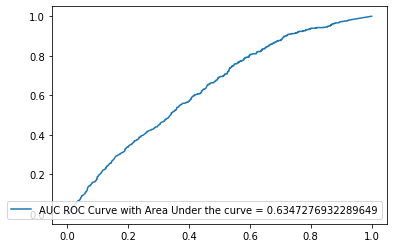

In [34]:
auc_roc_curve(rfc, X_test)

## Logistic Regression

In [35]:
# train
model.fit(x_train_res, y_train_res)

LogisticRegression()

In [36]:
# r^2 score
model.score(X_test, y_test)

0.5594083414161009

In [37]:
# pred
y_pred = model.predict(X_test)

### Model's performance

In [38]:
# call func
report(y_test, y_pred)

Accuracy =  0.5594083414161009
Precision =  0.2122823984526112
Recall =  0.7001594896331739
F1 Score =  0.32578849721706865


In [39]:
confusion_matrix(y_test, y_pred) 

array([[1868, 1629],
       [ 188,  439]], dtype=int64)

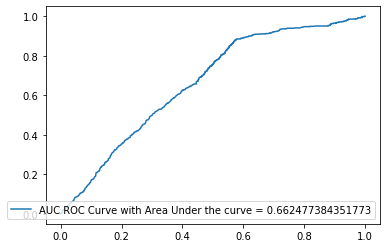

In [40]:
auc_roc_curve(model, X_test)

## Bagging Classifier

In [42]:
params_bag = {
        'n_estimators': [100, 1000],
        'max_samples' : [0.07, 0.5, 1],
        'warm_start': [True, False],
        }

gridbag = GridSearchCV(bag, params_bag, n_jobs = -1, cv = 5)

gridbag.fit(x_train_res, y_train_res) 
gridbag.best_params_

{'max_samples': 0.5, 'n_estimators': 100, 'warm_start': True}

In [43]:
bag = BaggingClassifier(n_estimators = 100, max_samples = 0.5, warm_start = True)

In [44]:
bag.fit(x_train_res, y_train_res)

bag.score(X_test, y_test)

0.6057225994180407

In [45]:
y_pred_bag = bag.predict(X_test)

### Model's performance

In [46]:
report(y_test, y_pred_bag)

Accuracy =  0.6057225994180407
Precision =  0.20738137082601055
Recall =  0.5645933014354066
F1 Score =  0.3033419023136247


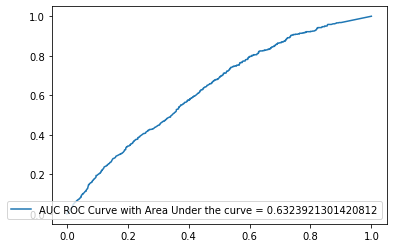

In [47]:
auc_roc_curve(bag, X_test)

- 50-50 oversampling-undersampling
- redes neuronales
- SVM
- random forest
- xgboost
- bagging boost